In [1]:
import clip
from torchvision import datasets
from PIL import Image
from IPython.display import display

In [2]:
#hack to normalize tensors easily
torch.Tensor.normalize = lambda x:x/x.norm(dim=-1, keepdim=True)

# database to perform the retrieval step
dataset = datasets.ImageFolder('simat_db/images/')
db = torch.load('data/clip_simat.pt').float()

model, prep = clip.load('ViT-B/32', device='cuda:0', jit=False)

Query Image:


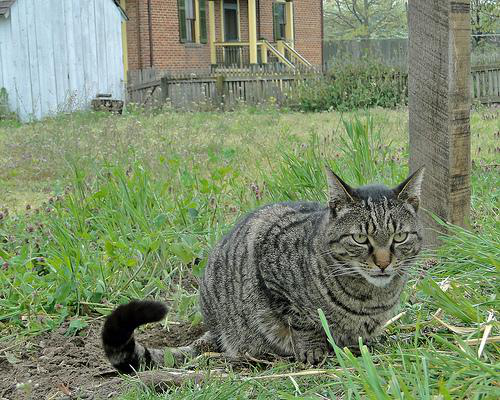

In [5]:
image = Image.open('simat_db/images/A cat sitting on a grass/98316.jpg')
print('Query Image:')
display(image)

CLIP retrieval without finetuning


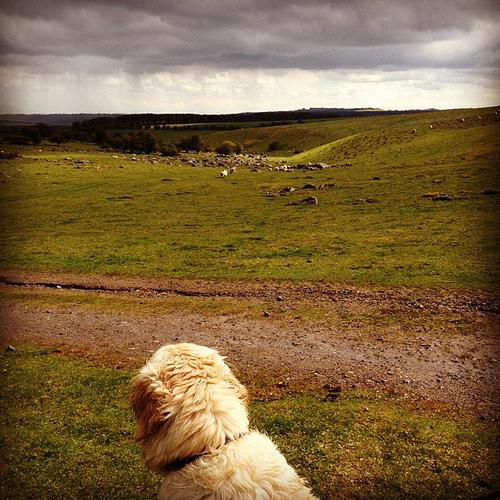

In [6]:
img_enc = model.encode_image(prep(image).unsqueeze(0).to('cuda:0')).float().cpu().detach().normalize()

txt = ['cat', 'dog']
txt_enc = model.encode_text(clip.tokenize(txt).to('cuda:0')).float().cpu().detach().normalize()

# now we perform the transformation step
lbd = 1
target_enc = img_enc + lbd * (txt_enc[1] - txt_enc[0])


retrieved_idx = (db @ target_enc.float().T).argmax(0).item()


print('CLIP retrieval without finetuning')
display(dataset[retrieved_idx][0])

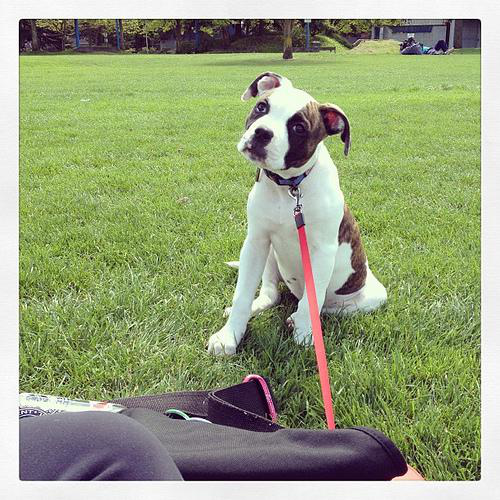

In [4]:
# optionally, we can apply a linear layer on top of the embeddings
heads = torch.load(f'data/head_clip_t=0.1.pt')
img_enc = heads['img_head'](img_enc).normalize()
txt_enc = heads['txt_head'](txt_enc).normalize()
db = heads['img_head'](db).normalize()


# now we perform the transformation step
lbd = 1
target_enc = img_enc + lbd * (txt_enc[1] - txt_enc[0])


retrieved_idx = (db @ target_enc.float().T).argmax(0).item()

print('CLIP retrieval with finetuning, tau=0.1')
display(dataset[retrieved_idx][0])